In [1]:
from typing import TypedDict, Annotated, Optional
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

======== INITIALIZE MEMORY, LLM, TOOLS ========

In [3]:
memory = MemorySaver()

In [4]:
model = ChatGroq(model="llama-3.3-70b-versatile")

model.invoke("What is RLHF?")

AIMessage(content="RLHF stands for Reinforcement Learning from Human Feedback. It's a technique used in artificial intelligence (AI) to fine-tune language models and improve their performance.\n\nIn traditional machine learning, models are trained on large datasets and learn to predict outcomes based on patterns in the data. However, when it comes to complex tasks like language understanding, human feedback is essential to guide the model towards more accurate and nuanced responses.\n\nRLHF involves the following steps:\n\n1. **Initial training**: A language model is pre-trained on a large dataset to learn the basics of language structure and patterns.\n2. **Human evaluation**: Human evaluators assess the model's responses to a set of prompts or questions, providing feedback in the form of ratings, corrections, or suggestions.\n3. **Reward model**: The human feedback is used to create a reward model, which assigns a score to each of the model's responses based on how well they align wi

In [5]:
search_tool = TavilySearchResults(max_results=3)

tools = [search_tool]

/tmp/ipykernel_13154/1163154442.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


In [6]:
llm_with_tools = model.bind_tools(tools)

llm_with_tools.invoke("What is the difference between RLHF and RLAIF?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wb3hpz72z', 'function': {'arguments': '{"query":"RLHF vs RLAIF"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 290, 'total_tokens': 313, 'completion_time': 0.053881236, 'prompt_time': 0.024594293, 'queue_time': 0.275299616, 'total_time': 0.078475529}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--629ccb9a-3df0-48f4-bd8f-33737444e460-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'RLHF vs RLAIF'}, 'id': 'wb3hpz72z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 290, 'output_tokens': 23, 'total_tokens': 313})

======== START BUILDING THE GRAPH WITH HIS UTILS ========

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [8]:
async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

In [9]:
async def tools_router(state: State):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls):
        return "tool_node"
    return END

In [10]:
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END
    }
)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

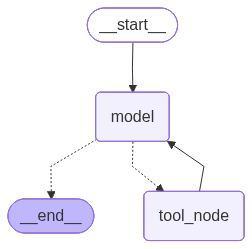

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

======== TESTING ========

In [14]:
config = {
    "configurable": {
        "thread_id": 1
    }
}

response = await graph.ainvoke(
    {
        "messages": [HumanMessage(content="When is the next spaceX launch?")], 
    },
    config=config
)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='52590bf8-d9f4-4d84-a296-a72b74c00601'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9hrw74m9g', 'function': {'arguments': '{"query":"next SpaceX launch date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.059582175, 'prompt_time': 0.024515094, 'queue_time': 0.098921605, 'total_time': 0.084097269}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--77847bf5-249b-430f-9e34-09df53a62e08-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch date'}, 'id': '9hrw74m9g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens

In [15]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events(
    {
        "messages": [HumanMessage(content="When is the next spacex launch?")],
    },
    config=config,
    version="v2",
):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'fa7db84f-46d5-45b9-8d04-29ef4bcb3271', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='e804e148-dcf2-4f80-999a-c80debb1a167')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'a5bd898a-cbbe-4b4e-b1a4-65487a745de2', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:98d429d8-4993-ed21-26fe-ab563660a636'}, 'parent_ids': ['fa7db84f-46d5-45b9-8d04-29ef4bcb3271']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa

In [16]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events(
    {
        "messages": [HumanMessage(content="What is the major difference between RLHF and RLAIF?")],
    },
    config=config,
    version="v2",
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The major difference between RLHF (Reinforcement Learning from Human Feedback) and RLAIF (Reinforcement Learning from AI Feedback) is the source of feedback used to train the AI model. RLHF relies on human feedback, where human evaluators provide feedback on the agent's actions, while RLAIF uses AI-generated feedback, where an AI system generates feedback on the agent's actions. RLHF is considered better for tasks that require ethical decision-making or nuanced human feedback, while RLAIF is more scalable and automated, making it suitable for applications requiring large-scale automation and rapid iterations.